### References
Run a couple of experiments and ensembles based on the following notebooks and ideas
* Notebook 1: [Link](https://www.kaggle.com/xhlulu/jigsaw-tpu-xlm-roberta)
* Notebook 2: [Link](https://www.kaggle.com/swannnn/jigsaw-tpu-xlm-roberta-e3ad07)
* Discussion 1: [Link](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/discussion/160980)

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import gc
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Average, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## Helper Functions

In [2]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text) # number
    text = re.sub(r'#[\S]+\b', '', text) # hash
    text = re.sub(r'@[\S]+\b', '', text) # mention
    text = re.sub(r'https?\S+', '', text) # link
    text = re.sub(r'\s+', ' ', text) # multiple white spaces
#     text = re.sub(r'\W+', ' ', text) # non-alphanumeric
    return text.strip()

In [3]:
def text_process(text):
    ws = text.split(' ')
    if(len(ws)>160):
        text = ' '.join(ws[:160]) + ' ' + ' '.join(ws[-32:])
    return text

In [4]:
def dict_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_mask=True, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen,
        truncation=True
    )
    
    return {
        "input_ids": np.array(enc_di['input_ids']),
        "attention_mask": np.array(enc_di['attention_mask'])
    }

In [5]:
# First load the real tokenizer
tokenizer = AutoTokenizer.from_pretrained('jplu/tf-xlm-roberta-large')

## TPU configs

In [6]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [7]:
# Configuration
MODEL = 'jplu/tf-xlm-roberta-large'
AUTO = tf.data.experimental.AUTOTUNE
SEED = 2020
EPOCHS_1 = 20
EPOCHS_2 = 2
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192
SHUFFLE = 2048
VERBOSE = 1

## Read data

In [8]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2 = pd.concat([train2[['comment_text', 'toxic']].query('toxic<=0.4'),
                    train2[['comment_text', 'toxic']].query('toxic>=0.6')])
train2.toxic = train2.toxic.round().astype(int)
train2 = train2.sample(frac = 1, random_state=SEED)
train3 = pd.read_csv("/kaggle/input/jigsaw-train-multilingual-coments-google-api/jigsaw-toxic-comment-train-google-es-cleaned.csv")
train4 = pd.read_csv("/kaggle/input/jigsaw-train-multilingual-coments-google-api/jigsaw-toxic-comment-train-google-fr-cleaned.csv")
train5 = pd.read_csv("/kaggle/input/jigsaw-train-multilingual-coments-google-api/jigsaw-toxic-comment-train-google-it-cleaned.csv")
train6 = pd.read_csv("/kaggle/input/jigsaw-train-multilingual-coments-google-api/jigsaw-toxic-comment-train-google-pt-cleaned.csv")
train7 = pd.read_csv("/kaggle/input/jigsaw-train-multilingual-coments-google-api/jigsaw-toxic-comment-train-google-ru-cleaned.csv")
train8 = pd.read_csv("/kaggle/input/jigsaw-train-multilingual-coments-google-api/jigsaw-toxic-comment-train-google-tr-cleaned.csv")

valid1 = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
valid2 = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-test-translated/jigsaw_miltilingual_valid_translated.csv')
valid2.rename(columns={'comment_text': 'old_comment_text', 'translated': 'comment_text'}, inplace=True)

test = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/test.csv')
test1 = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
test2 = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-test-translated/jigsaw_miltilingual_test_translated.csv')

sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [9]:
# sampling 50/50
train = pd.concat([
    train1[['comment_text', 'toxic']].query('toxic==1'),
    train1[['comment_text', 'toxic']].query('toxic==0').sample(n=len(train1[train1.toxic == 1]), random_state=SEED),
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=len(train2[train2.toxic == 1]), random_state=SEED),
    train3[['comment_text', 'toxic']].query('toxic==1'),
    train3[['comment_text', 'toxic']].query('toxic==0').sample(n=len(train3[train3.toxic == 1]), random_state=SEED),
    train4[['comment_text', 'toxic']].query('toxic==1'),
    train4[['comment_text', 'toxic']].query('toxic==0').sample(n=len(train4[train4.toxic == 1]), random_state=SEED),
    train5[['comment_text', 'toxic']].query('toxic==1'),
    train5[['comment_text', 'toxic']].query('toxic==0').sample(n=len(train5[train5.toxic == 1]), random_state=SEED),
    train6[['comment_text', 'toxic']].query('toxic==1'),
    train6[['comment_text', 'toxic']].query('toxic==0').sample(n=len(train6[train6.toxic == 1]), random_state=SEED),
    train7[['comment_text', 'toxic']].query('toxic==1'),
    train7[['comment_text', 'toxic']].query('toxic==0').sample(n=len(train7[train7.toxic == 1]), random_state=SEED),
    train8[['comment_text', 'toxic']].query('toxic==1'),
    train8[['comment_text', 'toxic']].query('toxic==0').sample(n=len(train8[train8.toxic == 1]), random_state=SEED),
    
])

train.toxic = train.toxic.round().astype(int)
train = train.sample(frac = 1, random_state=SEED)

valid = pd.concat([valid1, valid2])
valid = valid.sample(frac = 1, random_state=SEED)


train['comment_text'] = train.apply(lambda x: clean_text(x['comment_text']), axis=1)
valid['comment_text'] = valid.apply(lambda x: clean_text(x['comment_text']), axis=1)
test1['content'] = test1.apply(lambda x: clean_text(x['content']), axis=1)
test2['translated'] = test2.apply(lambda x: clean_text(x['translated']), axis=1)

train['comment_text'] = train['comment_text'].apply(lambda x: text_process(x))
valid['comment_text'] = valid['comment_text'].apply(lambda x: text_process(x))
test1['content'] = test1['content'].apply(lambda x: text_process(x))
test2['translated'] = test2['translated'].apply(lambda x: text_process(x))


n_train_steps = train.shape[0] // (BATCH_SIZE*8)
n_valid_steps = valid.shape[0] // (BATCH_SIZE)

del train1, train2, train3, train4, train5, train6, train7, train8
gc.collect()

3

In [10]:
%%time 
x_train = dict_encode(train.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_valid = dict_encode(valid.comment_text.values, tokenizer, maxlen=MAX_LEN)

x_test1 = dict_encode(test1.content.values, tokenizer, maxlen=MAX_LEN)
x_test2 = dict_encode(test2.translated.values, tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values
y_valid = valid.toxic.values

del train, valid
gc.collect()

CPU times: user 5min 22s, sys: 2.14 s, total: 5min 24s
Wall time: 5min 24s


0

## Dataset objects

In [11]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(SHUFFLE)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)


test1_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test1)
    .batch(BATCH_SIZE)
)

test2_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test2)
    .batch(BATCH_SIZE)
)

del x_train, x_valid, y_train, y_valid, x_test1, x_test2
gc.collect()

0

## Callbacks

In [12]:
lrs = ReduceLROnPlateau(monitor='val_accuracy', mode ='max', factor = 0.7, min_lr= 1e-7, verbose = 1, patience = 2)
es1 = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 5, restore_best_weights=True)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose = 1, patience = 1, restore_best_weights=True)
callbacks_list1 = [lrs,es1]
callbacks_list2 = [lrs,es2]

## Build model

In [13]:
def build_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    sequence_output = transformer({"input_ids": input_word_ids, "attention_mask": attention_mask})[0]

    avg_pool = GlobalAveragePooling1D()(sequence_output)
    max_pool = GlobalMaxPooling1D()(sequence_output)
    cls_token = Concatenate()([avg_pool, max_pool])
    
    samples = []
    for n in range(2):
        sample = Dropout(0.4)(cls_token)
        sample = Dense(1, activation='sigmoid', name=f'sample_{n}')(sample)
        samples.append(sample)
    
    out = Average(name='output')(samples)
    model = Model(inputs={
                "input_ids": input_word_ids,
                "attention_mask": attention_mask
                }, 
                outputs=out,
                name='XLM-R')
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
    
    return model

## Load to TPU

In [14]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "XLM-R"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 192)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 192)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode ((None, 192, 1024),  559890432   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 1024)         0           tf_roberta_model[0][0]      

## Run model

In [15]:
model_history_1 = model.fit(
    train_dataset,
    steps_per_epoch=n_train_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS_1,
    callbacks=callbacks_list1,
    verbose=VERBOSE
 )

Epoch 1/20
490/490 [==============================] - 242s 494ms/step - loss: 0.3218 - accuracy: 0.8573 - auc: 0.9371 - val_loss: 0.3841 - val_accuracy: 0.8148 - val_auc: 0.9269 - lr: 1.0000e-05
Epoch 2/20
490/490 [==============================] - 215s 439ms/step - loss: 0.2396 - accuracy: 0.9038 - auc: 0.9650 - val_loss: 0.3855 - val_accuracy: 0.8015 - val_auc: 0.9253 - lr: 1.0000e-05
Epoch 3/20
490/490 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 0.9096 - auc: 0.9675
Epoch 00003: ReduceLROnPlateau reducing learning rate to 6.9999998231651255e-06.
490/490 [==============================] - 215s 439ms/step - loss: 0.2289 - accuracy: 0.9096 - auc: 0.9675 - val_loss: 0.4092 - val_accuracy: 0.7971 - val_auc: 0.9275 - lr: 1.0000e-05
Epoch 4/20
490/490 [==============================] - 221s 452ms/step - loss: 0.2120 - accuracy: 0.9151 - auc: 0.9721 - val_loss: 0.2883 - val_accuracy: 0.8451 - val_auc: 0.9316 - lr: 7.0000e-06
Epoch 5/20
490/490 [====================

In [16]:
model_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_valid_steps,
    epochs=EPOCHS_2,
    callbacks=callbacks_list2,
    verbose=VERBOSE
)

Epoch 1/2
125/125 [==============================] - 57s 452ms/step - loss: 0.2294 - accuracy: 0.8943 - auc: 0.9294 - lr: 3.4300e-06
Epoch 2/2
125/125 [==============================] - 58s 462ms/step - loss: 0.1975 - accuracy: 0.9074 - auc: 0.9484 - lr: 3.4300e-06


## Blending

499/499 [==============================] - 55s 109ms/step


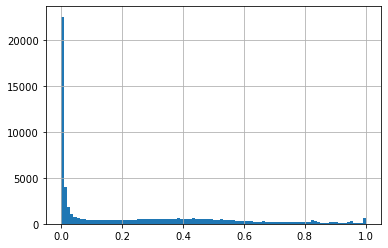

In [17]:
#Blending
multi_sub = model.predict(test1_dataset, verbose=1)
eng_sub = model.predict(test2_dataset, verbose=1)

sub['toxic'] = multi_sub*0.75 + eng_sub*0.25

#Post-processing
sub.loc[test["lang"] == "es", "toxic"] *= 1.11
sub.loc[test["lang"] == "fr", "toxic"] *= 1.06
sub.loc[test["lang"] == "it", "toxic"] *= 0.93
sub.loc[test["lang"] == "pt", "toxic"] *= 0.92
sub.loc[test["lang"] == "tr", "toxic"] *= 0.94

# min-max normalize
sub.toxic -= sub.toxic.min()
sub.toxic /= (sub.toxic.max() - sub.toxic.min())
sub.toxic.hist(bins=100, log=False, alpha=1)

## Submission

In [18]:
sub.to_csv('submission.csv', index=False)